In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Ensure GPU usage if available
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.12.0
Num GPUs Available: 0


In [3]:
# Load CIFAR-10 dataset
dataset_name = "cifar10"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, 
    split=["train", "test"], 
    as_supervised=True, 
    with_info=True
)

# Normalize pixel values to [0, 1]
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch to optimize performance
batch_size = 64  # Optimized for CPU performance
ds_train = ds_train.shuffle(10_000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Print dataset information
print(f"Dataset: {dataset_name}")
print(f"Training Samples: {ds_info.splits['train'].num_examples}")
print(f"Test Samples: {ds_info.splits['test'].num_examples}")
print(f"Image Shape: {ds_info.features['image'].shape}")
print(f"Classes: {ds_info.features['label'].num_classes}")

Dataset: cifar10
Training Samples: 50000
Test Samples: 10000
Image Shape: (32, 32, 3)
Classes: 10


2025-02-28 16:14:14.234419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2025-02-28 16:14:14.235400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2025-02-28 16:14:14.686114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

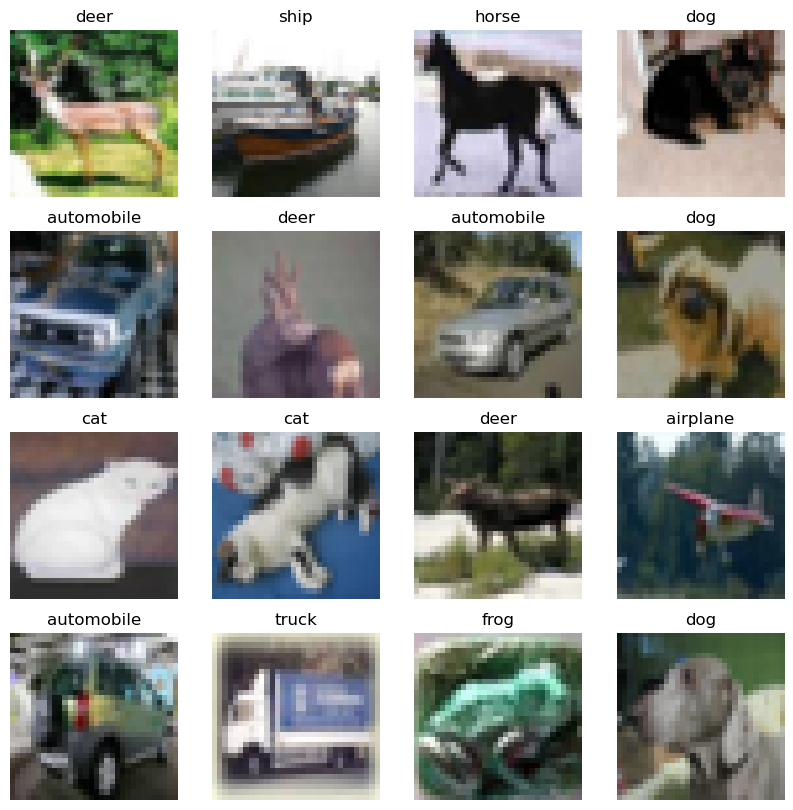

In [5]:
# Get class names
class_names = ds_info.features["label"].names

# Function to plot sample images
def plot_sample_images(dataset, class_names, num_images=16):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.show()

# Extract a small dataset for visualization
sample_images = ds_train.unbatch().take(16)

# Plot the images
plot_sample_images(sample_images, class_names)

2025-02-28 16:14:41.277401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2025-02-28 16:14:41.278533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


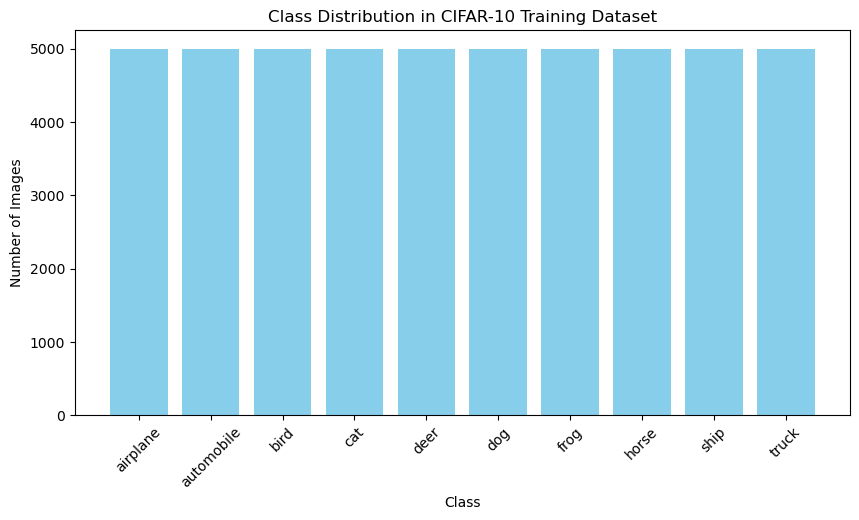

airplane: 5000 images
automobile: 5000 images
bird: 5000 images
cat: 5000 images
deer: 5000 images
dog: 5000 images
frog: 5000 images
horse: 5000 images
ship: 5000 images
truck: 5000 images


In [7]:
import collections

# Count occurrences of each class in the dataset
label_counts = collections.defaultdict(int)
for _, label in ds_train.unbatch():  
    label_counts[label.numpy()] += 1

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_names, [label_counts[i] for i in range(len(class_names))], color="skyblue")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in CIFAR-10 Training Dataset")
plt.xticks(rotation=45)
plt.show()

# Print class counts
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {label_counts[i]} images")

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),  # Prevent overfitting

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax")  # 10 output classes
    ])
    
    return model

# Create the model
model = create_model()

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20  # Set the number of epochs for training
history = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Epoch 1/20


2025-02-26 11:35:34.335903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2025-02-26 11:35:34.336395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


782/782 [==============================] - ETA: 0s - loss: 1.5987 - accuracy: 0.4580

2025-02-26 11:39:45.373904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2025-02-26 11:39:45.374559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


782/782 [==============================] - 257s 326ms/step - loss: 1.5987 - accuracy: 0.4580 - val_loss: 1.0820 - val_accuracy: 0.6191
Epoch 2/20
782/782 [==============================] - 221s 283ms/step - loss: 1.0003 - accuracy: 0.6480 - val_loss: 0.9857 - val_accuracy: 0.6573
Epoch 3/20
782/782 [==============================] - 183s 234ms/step - loss: 0.8282 - accuracy: 0.7099 - val_loss: 1.0396 - val_accuracy: 0.6490
Epoch 4/20
782/782 [==============================] - 177s 226ms/step - loss: 0.7373 - accuracy: 0.7429 - val_loss: 0.7833 - val_accuracy: 0.7331
Epoch 5/20
782/782 [==============================] - 172s 220ms/step - loss: 0.6644 - accuracy: 0.7695 - val_loss: 0.7150 - val_accuracy: 0.7580
Epoch 6/20
782/782 [==============================] - 174s 222ms/step - loss: 0.6070 - accuracy: 0.7900 - val_loss: 0.7339 - val_accuracy: 0.7530
Epoch 7/20
782/782 [==============================] - 201s 257ms/step - loss: 0.5609 - accuracy: 0.8062 - val_loss: 0.5768 - val_accura

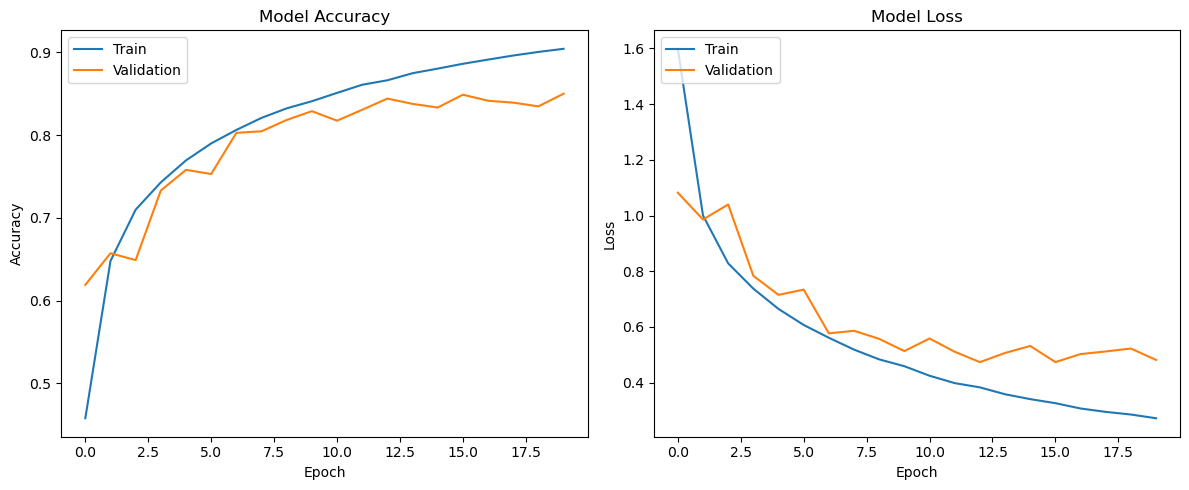

In [12]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

157/157 [==============================] - 5s 31ms/step - loss: 0.4813 - accuracy: 0.8500
Test Loss: 0.4813
Test Accuracy: 0.8500


2025-02-26 12:37:41.797883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2025-02-26 12:37:41.798803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 15ms/step


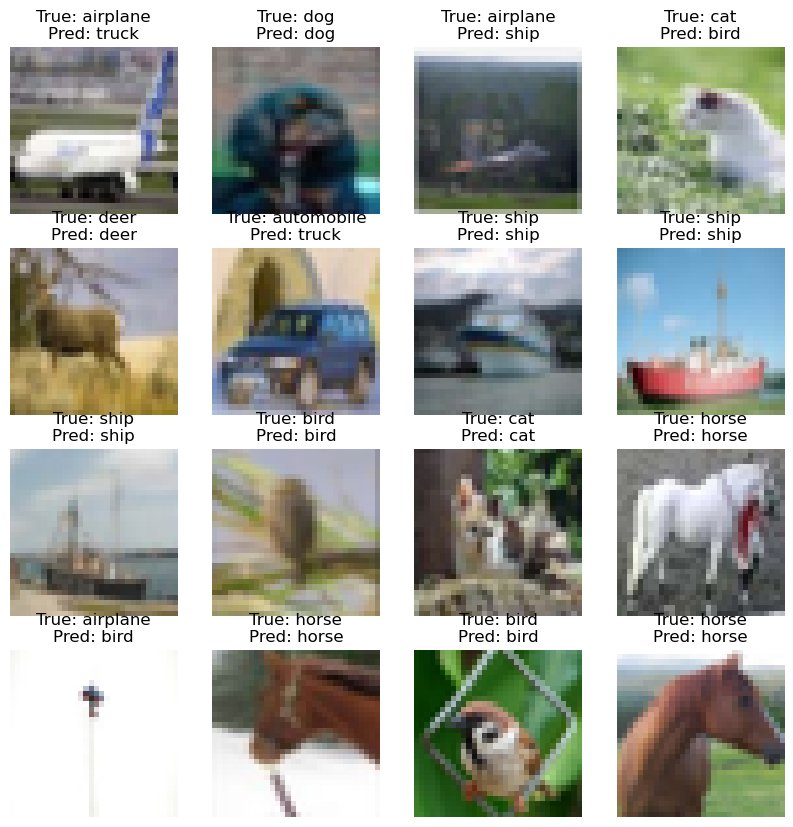

In [13]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optionally, make predictions on the test dataset and visualize some results
def plot_predictions(dataset, class_names, num_images=16):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        image = tf.expand_dims(image, axis=0)  # Add batch dimension
        predictions = model.predict(image)
        predicted_label = np.argmax(predictions[0])
        
        plt.subplot(4, 4, i + 1)
        plt.imshow(image[0].numpy())
        plt.title(f"True: {class_names[label.numpy()]}\nPred: {class_names[predicted_label]}")
        plt.axis("off")
    plt.show()

# Visualize predictions on the test dataset
plot_predictions(ds_test.unbatch().shuffle(100).take(16), class_names)

In [9]:

# Data Augmentation (High Impact, Low Time Cost)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
])

# Apply augmentation only on training data
def augment(image, label):
    image = data_augmentation(image)
    return image, label

In [10]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch for max efficiency
batch_size = 128  # Higher batch size speeds up training
ds_train = ds_train.shuffle(10_000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Optimized CNN Model (Lighter, Faster, Higher Accuracy)
def create_model():
    model = keras.Sequential([
        layers.Conv2D(96, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(96, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(192, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(192, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(384, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(384, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax")  # 10 classes
    ])
    
    return model

In [12]:
# Create and compile the model
model = create_model()
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),  # AdamW is better
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to optimize training
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=1, verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [ ]:
epochs = 20  
history = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[lr_scheduler, early_stopping])

Epoch 1/20


2025-02-26 19:17:34.925179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2025-02-26 19:17:34.926470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_25' with dtype resource
	 [[{{node Placeholder/_25}}]]


391/391 [==============================] - ETA: 0s - loss: 1.7911 - accuracy: 0.4115

2025-02-26 19:32:11.534979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2025-02-26 19:32:11.535772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


391/391 [==============================] - 899s 2s/step - loss: 1.7911 - accuracy: 0.4115 - val_loss: 2.4165 - val_accuracy: 0.1944 - lr: 0.0010
Epoch 2/20
391/391 [==============================] - 615s 2s/step - loss: 1.2665 - accuracy: 0.5559 - val_loss: 1.1380 - val_accuracy: 0.6003 - lr: 0.0010
Epoch 3/20
391/391 [==============================] - 596s 2s/step - loss: 1.0456 - accuracy: 0.6353 - val_loss: 1.2007 - val_accuracy: 0.6107 - lr: 0.0010
Epoch 4/20
391/391 [==============================] - 609s 2s/step - loss: 0.9254 - accuracy: 0.6749 - val_loss: 1.0495 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 5/20
391/391 [==============================] - 595s 2s/step - loss: 0.8415 - accuracy: 0.7064 - val_loss: 1.0291 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 6/20
391/391 [==============================] - 582s 1s/step - loss: 0.7809 - accuracy: 0.7299 - val_loss: 0.8197 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 7/20
391/391 [==============================] - ETA: 0s - loss: 0.726

In [18]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


79/79 [==============================] - 28s 358ms/step - loss: 0.4148 - accuracy: 0.8619
Test Loss: 0.4148
Test Accuracy: 0.8619


1/1 [==============================] - 0s 134ms/step


2025-02-27 07:36:03.756378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2025-02-27 07:36:03.756953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 18ms/step


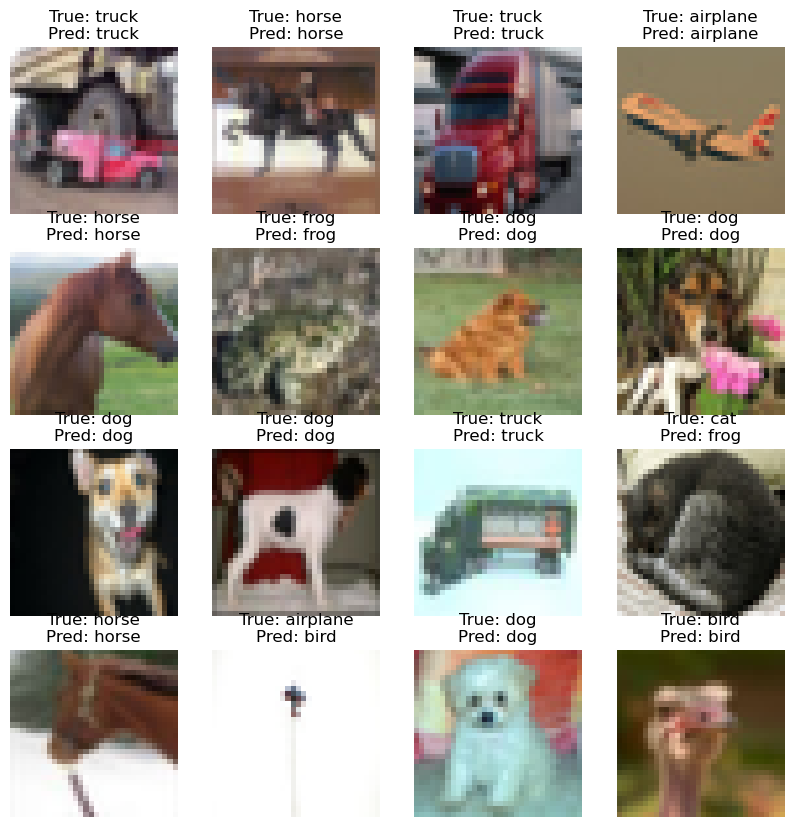

In [19]:
# Optionally, make predictions on the test dataset and visualize some results
def plot_predictions(dataset, class_names, num_images=16):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        image = tf.expand_dims(image, axis=0)  # Add batch dimension
        predictions = model.predict(image)
        predicted_label = np.argmax(predictions[0])
        
        plt.subplot(4, 4, i + 1)
        plt.imshow(image[0].numpy())
        plt.title(f"True: {class_names[label.numpy()]}\nPred: {class_names[predicted_label]}")
        plt.axis("off")
    plt.show()

# Visualize predictions on the test dataset
plot_predictions(ds_test.unbatch().shuffle(100).take(16), class_names)

In [52]:
model.save("cifar10_model.h5")  # Save model

In [13]:
# To load it later:
from tensorflow.keras.models import load_model
model = load_model("cifar10_model.h5")

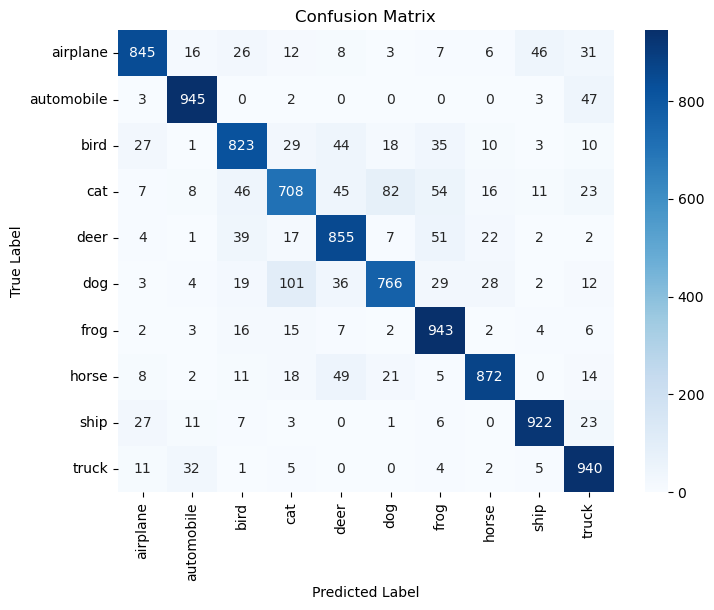

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels in one efficient pass
y_true = []
y_pred = []

for images, labels in ds_test:  # Batch-wise processing
    preds = model.predict(images, verbose=0)  # Batch prediction
    y_true.extend(labels.numpy())  # Convert tensor to NumPy
    y_pred.extend(np.argmax(preds, axis=1))  # Get predicted class indices

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.90      0.84      0.87      1000
  automobile       0.92      0.94      0.93      1000
        bird       0.83      0.82      0.83      1000
         cat       0.78      0.71      0.74      1000
        deer       0.82      0.85      0.84      1000
         dog       0.85      0.77      0.81      1000
        frog       0.83      0.94      0.88      1000
       horse       0.91      0.87      0.89      1000
        ship       0.92      0.92      0.92      1000
       truck       0.85      0.94      0.89      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



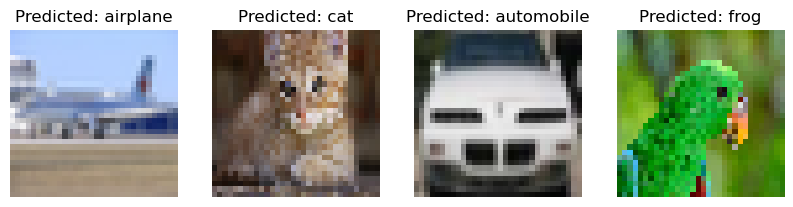

In [18]:
import os
from tensorflow.keras.preprocessing import image

# Get class names dynamically from CIFAR-10 dataset
class_names = tfds.builder(dataset_name).info.features["label"].names

def predict_new_images(image_folder, model):
    # Get all image file paths
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

    plt.figure(figsize=(10, 10))

    for i, img_path in enumerate(image_paths):
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model.predict(img_array, verbose=0)
        predicted_class = class_names[np.argmax(prediction)]  # Dynamically get class name

        # Display image with prediction
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis("off")

    plt.show()

# Folder containing test images
test_image_folder = "."  # Same directory as your code

# Run batch prediction
predict_new_images(test_image_folder, model)